# Korean Hate Speech Classifier
## Written by: [Jehwan Kim](github.com/kreimben)
## Date: 19th Feb 2024
## Referenced Paper: 
* [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)
* [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

### Load the word2vec model first,

In [1]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F


%matplotlib inline

### And then, load labeled data using pandas

In [2]:
dev_df = pd.read_csv('./labeled/dev.tsv', sep='\t')
train_df = pd.read_csv('./labeled/train.tsv', sep='\t')

In [3]:
train_df.head()

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate


In [4]:
dev_df.head()

,comments,contain_gender_bias,bias,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none
1,지현우 나쁜놈,False,none,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive


### In `hate` column, `offensive`, `none`, `hate`.
### In `contain_gender_bias` column, `True`, `False`.
### In `bias` column, `none`, `gender`, `others`.

In [5]:
# combine train and dev data.
df = pd.concat([dev_df, train_df], ignore_index=True)
df.sample(5)

,comments,contain_gender_bias,bias,hate
4739,애기날때 쉬싸는곳 찢어질정도로 아프다고 하지만 군대갔다오는게 더 힘들다... 낮는건...,True,gender,offensive
4741,애기랑 꼭 나와주세요. 나~중에요^^,False,none,none
4046,솔직히 남태훈두고 두여자가 서로차지할려고 싸운거 아니냐?,False,none,offensive
8022,한남들 또 난리났다 쯧쯧..,True,gender,offensive
2113,냅두지 왜 막았어요? 그래봤자 한남충 소리들을텐데..,True,gender,hate


In [6]:
df.hate.value_counts(), dev_df.contain_gender_bias.value_counts(), dev_df.bias.value_counts()

(hate
 none         3646
 offensive    2688
 hate         2033
 Name: count, dtype: int64,
 contain_gender_bias
 False    404
 True      67
 Name: count, dtype: int64,
 bias
 none      342
 gender     67
 others     62
 Name: count, dtype: int64)

### Load words data and tokeniser from past project.

In [7]:
import pickle

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('words.pkl', 'rb') as handle:
    words = pickle.load(handle)

In [8]:
tokenizer.tokenize('혼전임신은 미리 조심하지 못한 여자 잘못이 크다')

['혼전', '임신', '은', '미리', '조심', '하지', '못한', '여자', '잘못', '이', '크다']

In [9]:
from utils.stopwords import STOP_WORDS


def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    preprocess = lambda x: [w for w in x if w not in STOP_WORDS]
    return preprocess(tokens)

In [10]:
df['tokens'] = df['comments'].apply(tokenize)
# 공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.
df['hate'] = df['hate'].replace(['none', 'offensive', 'hate'], [0, 1, 1])
df['contain_gender_bias'] = df['contain_gender_bias'].replace([True, False], [1, 0])
df.head()

C:\Users\aksid\AppData\Local\Temp\ipykernel_9756\1445675357.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['hate'] = df['hate'].replace(['none', 'offensive', 'hate'], [0, 1, 1])
C:\Users\aksid\AppData\Local\Temp\ipykernel_9756\1445675357.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['contain_gender_bias'] = df['contain_gender_bias'].replace([True, False], [1, 0])


,comments,contain_gender_bias,bias,hate,tokens
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,0,none,0,"[송중기, 시대, 극은, 믿고, 본다., 첫회, 신선, 았다, .]"
1,지현우 나쁜놈,0,none,1,"[지현우, 나쁜놈]"
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,0,none,1,"[알바, 쓰고, 많이, 만들면, 되지, 돈, 욕심, 으면, 골목, 식당, 왜나온겨,..."
3,설마 ㅈ 현정 작가 아니지??,1,gender,1,"[ㅈ, 현정, 작가, ??]"
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,0,none,1,"[이미자, 송혜교, 돈이, 그리, 으면, 탈세, 말고, 그돈, 평소, 불우이웃, 기..."


In [11]:
vocab_size = len(words.keys())
vocab_size

149726

### Vectorise

In [12]:
with open('vectorizer.pkl', 'rb') as handle:
    vectorizer = pickle.load(handle)

### Encoding

In [13]:
df['encoding'] = df['comments'].apply(vectorizer.encode_a_doc_to_list)
df.encoding

0         [13834, 366, 55661, 671, 1342, 16079, 423, 432]
1                                                  [6021]
2       [750, 384, 2886, 332, 1898, 10604, 3279, 21690...
3                               [1990, 1092, 75890, 9257]
4       [84631, 533, 15596, 533, 454, 171, 779, 5641, ...
                              ...                        
8362                                        [2805, 11384]
8363                       [2805, 7442, 3105, 3781, 3744]
8364              [46019, 1577, 58, 591, 1505, 22957, 58]
8365    [4232, 882, 75943, 769, 4678, 887, 22943, 4270...
8366       [396, 1469, 1727, 36544, 1694, 30, 3644, 5144]
Name: encoding, Length: 8367, dtype: object

In [14]:
X_data = df['encoding']
y_data = df['hate']
print(y_data.value_counts())
len(X_data), len(y_data), len(X_data) == len(y_data)

hate
1    4721
0    3646
Name: count, dtype: int64


(8367, 8367, True)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.1, random_state=42, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, random_state=42, stratify=y_train)

y_train.value_counts()

hate
1    3824
0    2953
Name: count, dtype: int64

In [16]:
print('공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.')
print('--------훈련 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_train.value_counts()[1] / len(y_train) * 100, 3)}%')
print(f'일반 댓글 = {round(y_train.value_counts()[0] / len(y_train) * 100, 3)}%')
print('--------검증 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_valid.value_counts()[1] / len(y_valid) * 100, 3)}%')
print(f'일반 댓글 = {round(y_valid.value_counts()[0] / len(y_valid) * 100, 3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_test.value_counts()[1] / len(y_test) * 100, 3)}%')
print(f'일반 댓글 = {round(y_test.value_counts()[0] / len(y_test) * 100, 3)}%')

공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.
--------훈련 데이터의 비율-----------
혐오 댓글 = 56.426%
일반 댓글 = 43.574%
--------검증 데이터의 비율-----------
혐오 댓글 = 56.441%
일반 댓글 = 43.559%
--------테스트 데이터의 비율-----------
혐오 댓글 = 56.392%
일반 댓글 = 43.608%


### Padding

댓글의 최대 길이 : 39
댓글의 평균 길이 : 9.46200383650583


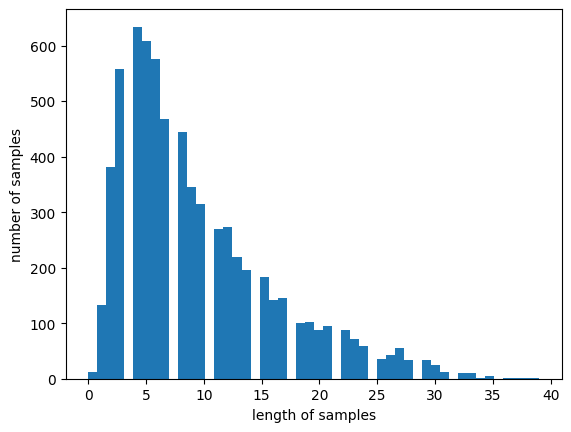

In [17]:
print('댓글의 최대 길이 :', max(len(review) for review in X_train))
print('댓글의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
max_len = max(len(review) for review in X_train)

### 길이가 길지 않아서 그냥 최대값 그대로 진행합니다. (패딩)

In [19]:
def pad_sequences(sentences: [[int]], max_len: int) -> np.ndarray:
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [20]:
padded_X_train = pad_sequences(X_train, max_len=max_len)
padded_X_valid = pad_sequences(X_valid, max_len=max_len)
padded_X_test = pad_sequences(X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (6777, 39)
검증 데이터의 크기 : (753, 39)
테스트 데이터의 크기 : (837, 39)


In [21]:
padded_X_test[:5, :]

array([[  381, 58445,   158, 16388,   854,   708,   232, 58445,  2251,
         1335, 25020,   912,   745,  1439, 18849,   232,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  700,  1380,   986, 55331,   239,   865,    89,  6507, 11596,
         5314,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 2159,   894,   599,  2152,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [19051,  3685,  5535,   401,  1689,   282, 34519, 1

### Check the GPU models (cuz I use M2 mac and 4080 on pc either)

In [22]:
from utils.device import get_device

device = get_device()

"cuda" is your training device.


### Modeling

In [23]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 0, 1, 1, 1])


In [24]:
class TextCNN(torch.nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(TextCNN, self).__init__()

        # 오직 하나의 종류의 필터만 사용함.
        self.num_filter_sizes = 1  # 윈도우 5짜리 1개만 사용
        self.num_filters = 256

        self.word_embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)
        # 윈도우 5짜리 1개만 사용
        self.conv1 = torch.nn.Conv1d(128, self.num_filters, 5, stride=1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

    def forward(self, inputs):
        # word_embed(inputs).shape == (배치 크기, 문장길이, 임베딩 벡터의 차원)
        # word_embed(inputs).permute(0, 2, 1).shape == (배치 크기, 임베딩 벡터의 차원, 문장 길이)
        embedded = self.word_embed(inputs).permute(0, 2, 1)

        # max를 이용한 maxpooling
        # conv1(embedded).shape == (배치 크기, 커널 개수, 컨볼루션 연산 결과) == ex) 32, 256, 496
        # conv1(embedded).permute(0, 2, 1).shape == (배치 크기, 컨볼루션 연산 결과, 커널 개수)
        # conv1(embedded).permute(0, 2, 1).max(1)[0]).shape == (배치 크기, 커널 개수)
        x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

        # y_pred.shape == (배치 크기, 분류할 카테고리의 수)
        y_pred = self.fc1(self.dropout(x))

        return y_pred

In [28]:

import torch


class TextCNNLightning(L.LightningModule):
    def __init__(self, vocab_size, num_labels):
        super().__init__()

        # Parameters
        self.num_filter_sizes = 1  # Only using one kind of filter
        self.num_filters = 256

        # Layers
        self.word_embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)
        self.conv1 = torch.nn.Conv1d(128, self.num_filters, 5, stride=1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

    def forward(self, inputs):
        # Word embedding
        embedded = self.word_embed(inputs).permute(0, 2, 1)

        # Convolution and max pooling
        x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

        # Dropout and fully connected layer
        y_pred = self.fc1(self.dropout(x))

        return y_pred

    def configure_optimizers(self):
        # Adam optimizer with default parameters
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Log loss
        self.log("train_loss", loss)

        # Return loss
        return loss

    def validation_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch
        inputs, labels = inputs.to(self.device), labels.to(self.device)

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = (outputs.argmax(dim=1) == labels).float().mean().item()

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def test_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch
        inputs, labels = inputs.to(self.device), labels.to(self.device)

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = (outputs.argmax(dim=1) == labels).float().mean().item()

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def train_dataloader(self):
        encoded_train = torch.tensor(padded_X_train).to(torch.int32)
        train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=7)
        return train_dataloader

    def val_dataloader(self):
        encoded_valid = torch.tensor(padded_X_valid).to(torch.int32)
        valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
        valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=7)
        return valid_dataloader

    def test_dataloader(self):
        encoded_test = torch.tensor(padded_X_test).to(torch.int32)
        test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)
        return test_dataloader

In [29]:
model = TextCNNLightning(vocab_size=vocab_size, num_labels=len(set(y_train)))

### Train

In [36]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=1, accelerator="auto", devices="auto", strategy="auto")
trainer.fit(model=model)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\aksid\PycharmProjects\KoreanHateSpeechClassifier\venv\lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type      | Params
-----------------------------------------
0 | word_embed | Embedding | 19.2 M
1 | conv1      | Conv1d    | 164 K 
2 | dropout    | Dropout   | 0     
3 | fc1        | Linear    | 514   
-----------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.318    Total estimated model params size (MB)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [31]:
trainer.test()

C:\Users\aksid\PycharmProjects\KoreanHateSpeechClassifier\venv\lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
